In [7]:
from IPython.display import clear_output

# Install the requiring library
!pip install --upgrade numpy
!pip install --upgrade tensorflow

# Clear the output
clear_output()

In [8]:
import os
import zipfile

import pandas as pd

In [9]:
# Unzip the data
path_zip = "data/zip/"
path_unzip = "data/raw/"
files = os.listdir(path_zip)

for file in files:
    with zipfile.ZipFile(path_zip + file, 'r') as zip_ref:
        zip_ref.extractall(path_unzip)

In [10]:
# Concat the files
files = os.listdir(path_unzip)
df = pd.concat([pd.read_csv(path_unzip + file, index_col=0) for file in files])

# Convert index to datetime
df.index = pd.to_datetime(df.index)

### Tp begin at this points

In [11]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
# Resample the data 
df = df.resample("H").mean()

# Fill the gap of data
df = df.ffill().bfill()

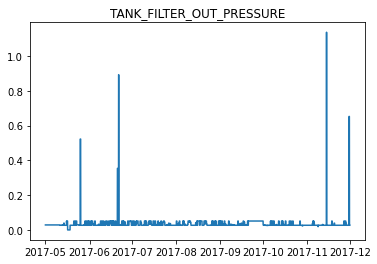

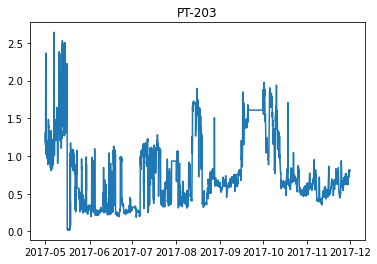

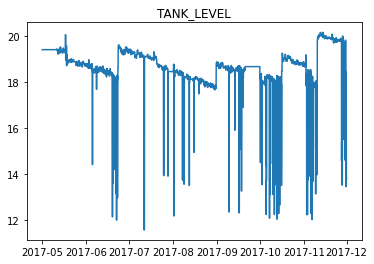

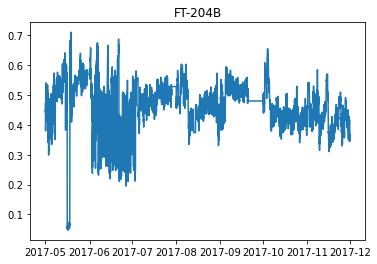

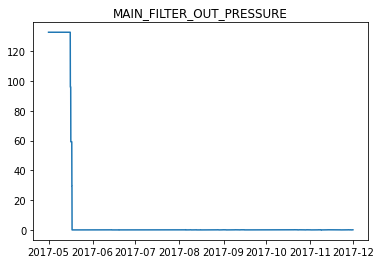

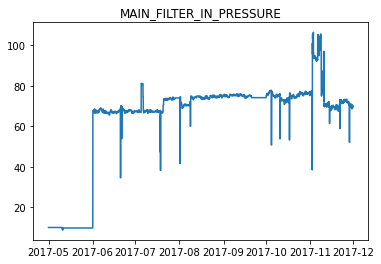

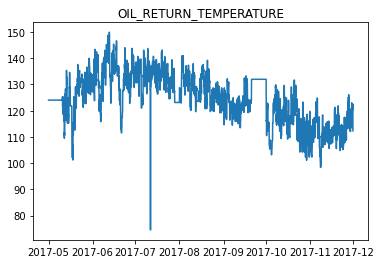

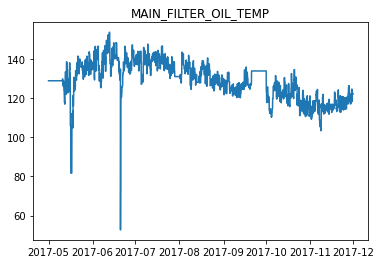

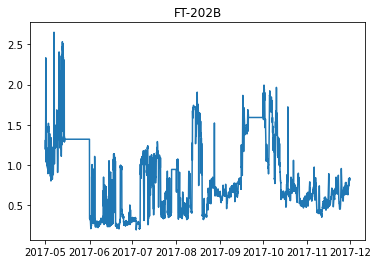

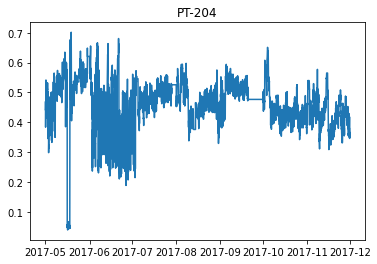

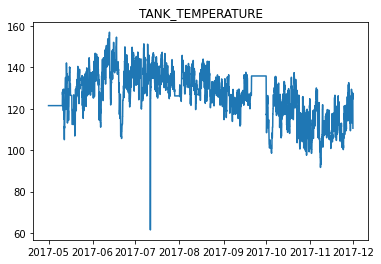

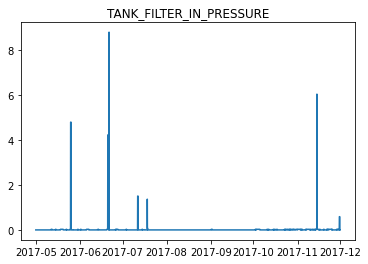

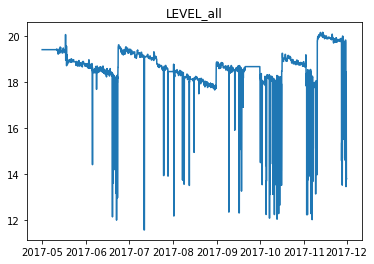

In [13]:
# Plot the data 
for col in df.columns:
    fig = plt.Figure()
    plt.plot(df.index,df[col])
    plt.title(col)
    plt.show()

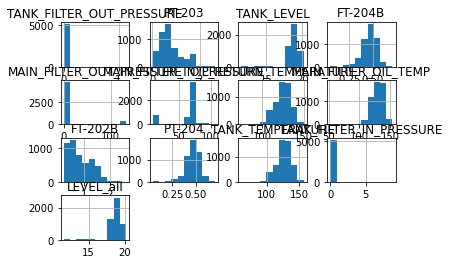

In [14]:
# Histogram of the data
df.hist()
plt.show()

In [15]:
# Correlation matrices
cor = df.corr()
cor.style.background_gradient(cmap="coolwarm")
cor

,TANK_FILTER_OUT_PRESSURE,PT-203,TANK_LEVEL,FT-204B,MAIN_FILTER_OUT_PRESSURE,MAIN_FILTER_IN_PRESSURE,OIL_RETURN_TEMPERATURE,MAIN_FILTER_OIL_TEMP,FT-202B,PT-204,TANK_TEMPERATURE,TANK_FILTER_IN_PRESSURE,LEVEL_all
TANK_FILTER_OUT_PRESSURE,1.000000,-0.012851,-0.038950,0.078350,-0.047536,-0.008229,0.054208,0.035802,-0.006392,0.078238,0.040592,0.811984,-0.038950
PT-203,-0.012851,1.000000,-0.064667,0.163121,0.352976,-0.108151,0.002742,0.007743,0.866290,0.160838,0.014301,-0.060224,-0.064667
TANK_LEVEL,-0.038950,-0.064667,1.000000,-0.043984,0.206474,-0.254739,0.052791,0.025603,-0.033930,-0.043863,0.016917,-0.047906,1.000000
FT-204B,0.078350,0.163121,-0.043984,1.000000,0.082711,-0.157407,0.049264,0.178344,0.157230,0.997656,-0.029533,0.117499,-0.043984
MAIN_FILTER_OUT_PRESSURE,-0.047536,0.352976,0.206474,0.082711,1.000000,-0.667828,-0.040023,-0.052970,0.325036,0.080926,-0.095852,-0.022797,0.206474
MAIN_FILTER_IN_PRESSURE,-0.008229,-0.108151,-0.254739,-0.157407,-0.667828,1.000000,-0.128036,-0.128838,-0.405632,-0.162052,-0.061274,-0.052211,-0.254739
OIL_RETURN_TEMPERATURE,0.054208,0.002742,0.052791,0.049264,-0.040023,-0.128036,1.000000,0.896544,0.023421,0.049230,0.957608,-0.073055,0.052791
MAIN_FILTER_OIL_TEMP,0.035802,0.007743,0.025603,0.178344,-0.052970,-0.128838,0.896544,1.000000,-0.004737,0.179146,0.856594,-0.074106,0.025603
FT-202B,-0.006392,0.866290,-0.033930,0.157230,0.325036,-0.405632,0.023421,-0.004737,1.000000,0.160021,0.033017,-0.030697,-0.033930
PT-204,0.078238,0.160838,-0.043863,0.997656,0.080926,-0.162052,0.049230,0.179146,0.160021,1.000000,-0.029469,0.115466,-0.043863


In [22]:
# Preprocess the data 
norm = MinMaxScaler()

np_oil = df["OIL_RETURN_TEMPERATURE"].values

norm = MinMaxScaler().fit(np_oil.reshape((-1, 1)))
np_oil = norm.transform(np_oil.reshape((-1, 1))).reshape((-1))

np_dates = df.index.values
window_size=11


np_oil = np_oil[:-(np_oil.shape[0]%window_size)]
np_oil = np_oil.reshape((-1,window_size))
np_dates = np_dates[:-(np_dates.shape[0]%window_size)]
np_dates = np_dates.reshape((-1,window_size))

X = np_oil[:,:-1]
y = np_oil[:,-1]
dates_X = np_dates[:,:-1]
dates_y = np_dates[:,-1]

X = np.expand_dims(X, axis=1)

In [24]:
# Split the dataset for train and test purpose
X_train,X_test,y_train,y_test,dates_X_train,dates_X_test,dates_y_train,dates_y_test = train_test_split(X,y,dates_X,dates_y,test_size=0.2,shuffle=False)

In [25]:
# Create the model
model = Sequential()
model.add(LSTM(4, input_shape=(1, X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2022-03-31 11:50:12.670278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 11:50:12.670382: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 11:50:12.670435: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PFDEV-U0082.beta.forties.int): /proc/driver/nvidia/version does not exist
2022-03-31 11:50:12.670983: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
372/372 [==============================] - 1s 922us/step - loss: 0.1176
Epoch 2/100
372/372 [==============================] - 0s 877us/step - loss: 0.0038
Epoch 3/100
372/372 [==============================] - 0s 888us/step - loss: 0.0033
Epoch 4/100
372/372 [==============================] - 0s 903us/step - loss: 0.0028
Epoch 5/100
372/372 [==============================] - 0s 880us/step - loss: 0.0024
Epoch 6/100
372/372 [==============================] - 0s 892us/step - loss: 0.0020
Epoch 7/100
372/372 [==============================] - 0s 905us/step - loss: 0.0019
Epoch 8/100
372/372 [==============================] - 0s 899us/step - loss: 0.0016
Epoch 9/100
372/372 [==============================] - 0s 870us/step - loss: 0.0015
Epoch 10/100
372/372 [==============================] - 0s 880us/step - loss: 0.0014
Epoch 11/100
372/372 [==============================] - 0s 881us/step - loss: 0.0014
Epoch 12/100
372/372 [==============================] - 0s 871us/step - lo

In [27]:
# make predictions
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

# calculate root mean squared error
score_train = mean_squared_error(y_train, predict_train.reshape((-1)))
print(f'Train Score: {score_train} MSE')
score_test = mean_squared_error(y_test, predict_test.reshape((-1)))
print(f'Test Score: {score_test} MSE')

Train Score: 0.0005472994454986374 MSE
Test Score: 0.0014874651851886495 MSE


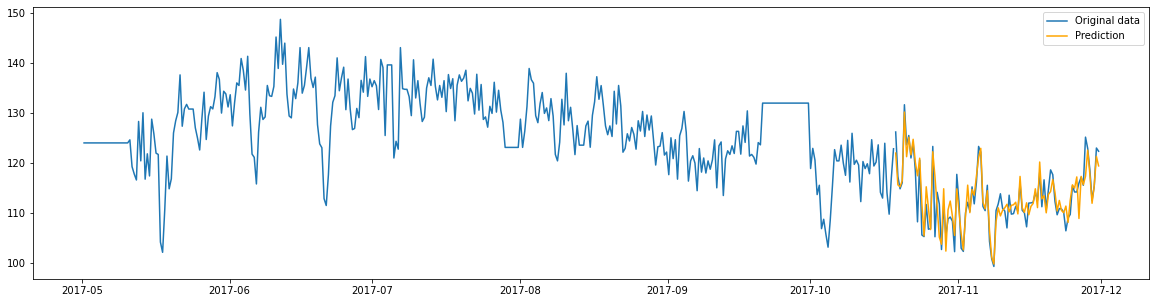

In [32]:
fig = plt.Figure()

plt.rcParams['figure.figsize'] = [20, 5]

plt.plot(dates_y_train, norm.inverse_transform(y_train.reshape(-1, 1)), c='#1f77b4', label='Original data')
plt.plot(dates_y_test, norm.inverse_transform(y_test.reshape(-1, 1)), c='#1f77b4')
plt.plot(dates_y_test, norm.inverse_transform(predict_test), color="orange", label='Prediction')
plt.legend()

plt.show()